### breakdown performance on our best model
##### Other metrics:
- For each video, how many true positives out of the top 10 were predicted: percentage
- how many of the predicted cases got the first label correct (highest probability)


In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from report import report_performance,make_top_n_pred_df,get_label
from ast import literal_eval

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [138]:
df =  pd.read_pickle("logistic_video_rgb.pkl")# change this to any file
df.head()

,pseudo_id,label_true,label_pred,predict_proba
0,PA8l,"[89, 201]","[3, 26, 13, 463, 8]","[1.0, 1.0, 0.9999810457229614, 0.0274487733840..."
1,fx8l,"[15, 277, 400]","[6, 11, 25, 16, 33]","[1.5098697403459482e-08, 1.4216440469283498e-0..."
2,8s8l,[25],"[14, 0, 2, 25, 1]","[0.0004627108573913574, 2.9847021778550697e-06..."
3,x48l,[305],"[2, 55, 387, 79, 17]","[1.0, 1.0, 0.9999998211860657, 0.9994552135467..."
4,HP8l,"[4, 10, 13]","[4, 3, 9, 13, 71]","[4.525904660113156e-05, 3.049834504054161e-06,..."


In [139]:
# label_dict = pd.read_csv("vocabulary.csv")

# df =  pd.read_csv("logistic_video_test.csv") # read_in any csv
top_n_lab_pred = 5

df["true_name"] = get_label(df.label_true,10000,label_dict,get_names=True)
df['n_labels'] = df.label_true.apply(len)
df['n_TP'] = df.apply(lambda row: np.sum(np.in1d(row['label_pred'], row['label_true'])), axis=1)
df['top_label'] = df.label_pred.apply(lambda x: x[0])
df['first_correct'] = df.apply(lambda row: row['top_label']in row['label_true'], axis=1)

In [140]:
df.head()

,pseudo_id,label_true,label_pred,predict_proba,true_name,n_labels,n_TP,top_label,first_correct
0,PA8l,"[89, 201]","[3, 26, 13, 463, 8]","[1.0, 1.0, 0.9999810457229614, 0.0274487733840...","[House, Wii]",2,0,3,False
1,fx8l,"[15, 277, 400]","[6, 11, 25, 16, 33]","[1.5098697403459482e-08, 1.4216440469283498e-0...","[Animal, Race track, Chipmunk]",3,0,6,False
2,8s8l,[25],"[14, 0, 2, 25, 1]","[0.0004627108573913574, 2.9847021778550697e-06...",[Trailer (promotion)],1,1,14,False
3,x48l,[305],"[2, 55, 387, 79, 17]","[1.0, 1.0, 0.9999998211860657, 0.9994552135467...",[Slide show],1,0,2,False
4,HP8l,"[4, 10, 13]","[4, 3, 9, 13, 71]","[4.525904660113156e-05, 3.049834504054161e-06,...","[Musician, String instrument, Musical ensemble]",3,2,4,True


In [141]:
# how many true positives out of the top 5 were predicted:
mean_n_labels = np.mean(df['n_labels'])
mean_n_pos = np.mean(df['n_TP'])
print("On average each video has %.1f labels, and our model predicts %.1f true positive labels on average for each video."%(mean_n_labels,mean_n_pos)) 
top_n_lab_pred = 5
precision = df['n_TP']/top_n_lab_pred
print(np.mean(precision)) # not sure how to interpret this
first_correct_percent = df['first_correct'].sum()/len(df)
print("Percentage of observations has the predicted most likely label actually in the true labels: %.2f ."%(first_correct_percent*100))

On average each video has 2.9 labels, and our model predicts 1.1 true positive labels on average for each video.
0.21811594202898552
Percentage of observations has the predicted most likely label actually in the true labels: 42.75 .


##### video with most popular 50, 50-100, 100-150 ... labels

In [142]:
import eval_util as eval
from report import report_performance,make_top_n_pred_df,get_label

df_raw =  pd.read_pickle("logistic_video_rgb_raw.pkl")#,converters={'predict_proba': literal_eval})
df = df.merge(df_raw, left_on='pseudo_id',right_on="pseudo_id")


In [159]:

bound = np.arange(0,1000,50)
gAP_list = np.zeros(len(bound))
PERR_list = np.zeros(len(bound))
HIT1_list=np.zeros(len(bound))
F1_optimal_list = np.zeros(len(bound))
thresh_optimal_list=np.zeros(len(bound))
for i in range(len(bound)):
    low_bound = bound[i]
    high_bound = low_bound+50
    video_w_poplabels = df.loc[df.label_true.apply(lambda x: np.sum((np.array(x)>=low_bound) & (np.array(x)<high_bound))>0)]
    y_predproba_topN = np.array(video_w_poplabels.y_predproba.values.tolist())
    y_topN = np.array(video_w_poplabels.y_true.values.tolist())
    gAP_list[i],PERR_list[i], HIT1_list[i],F1_optimal_list[i],thresh_optimal_list[i]= report_performance(y_predproba_topN,y_topN)
    #thresh_optimal[i] = thresh_optimal

gAP = 0.1545, PERR = 0.3863, HIT1 = 0.6172
Optimal weigthed F1 score 0.3641 when treshold = 0.0500
gAP = 0.1277, PERR = 0.2856, HIT1 = 0.5208
Optimal weigthed F1 score 0.3019 when treshold = 0.2600
gAP = 0.1722, PERR = 0.3389, HIT1 = 0.6667
Optimal weigthed F1 score 0.3458 when treshold = 0.0100
gAP = 0.1162, PERR = 0.2208, HIT1 = 0.4074
Optimal weigthed F1 score 0.2426 when treshold = 0.0100
gAP = 0.0928, PERR = 0.2454, HIT1 = 0.4737
Optimal weigthed F1 score 0.2638 when treshold = 0.0100
gAP = 0.0615, PERR = 0.2564, HIT1 = 0.3529
Optimal weigthed F1 score 0.2624 when treshold = 0.4700
gAP = 0.0926, PERR = 0.2490, HIT1 = 0.6250
Optimal weigthed F1 score 0.2524 when treshold = 0.0200
gAP = 0.0244, PERR = 0.2068, HIT1 = 0.3684
Optimal weigthed F1 score 0.1712 when treshold = 0.9100
gAP = 0.0580, PERR = 0.2263, HIT1 = 0.4667
Optimal weigthed F1 score 0.2253 when treshold = 0.0200
gAP = 0.1167, PERR = 0.2429, HIT1 = 0.5000
Optimal weigthed F1 score 0.3179 when treshold = 0.0300
gAP = 0.25

/var/folders/f2/d1mj0jcx0_g5cf_sw9qfpnwc0000gn/T/ipykernel_28235/1599530425.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


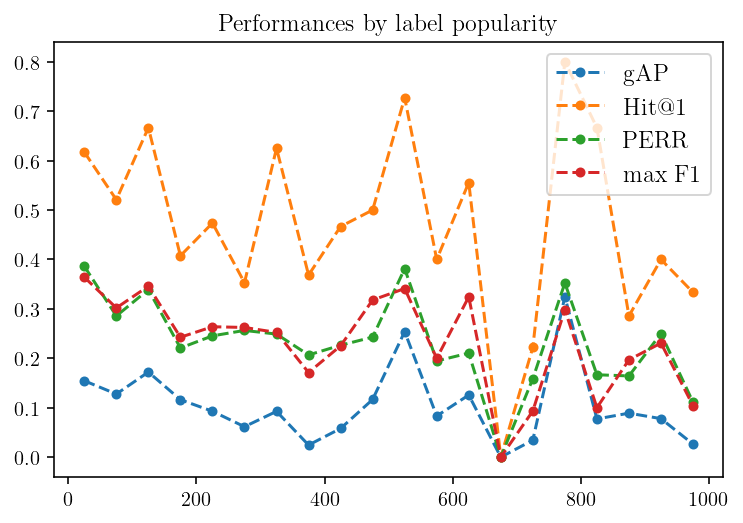

In [182]:
fig,ax = plt.subplots(figsize=(6,4))
ax.plot(bound+25,gAP_list,label="gAP",marker='o', linestyle='dashed',markersize=4)
ax.plot(bound+25,HIT1_list,label="Hit@1",marker='o', linestyle='dashed',markersize=4)
ax.plot(bound+25,PERR_list,label="PERR",marker='o', linestyle='dashed',markersize=4)
ax.plot(bound+25,F1_optimal_list,label="max F1",marker='o', linestyle='dashed',markersize=4)
#ax.plot(bound+25,thresh_optimal_list,label="best threshold",marker='o', linestyle='dashed',markersize=4)
ax.legend(fontsize=12)
ax.set_title("Performances by label popularity")
fig.show()

##### performance by video category
